# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [14]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker

# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [15]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter = ';')

In [24]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [25]:
# Get the number of rows and columns of azdias dataset
print('There are {} rows and {} columns.'.format(azdias.shape[0],azdias.shape[1]))

# Check the first 5 rows of the azdias dataset
azdias.head()

There are 891221 rows and 85 columns.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
# Get the number of rows and columns of the feat_info dataset
print('There are {} rows and {} columns.'.format(feat_info.shape[0],feat_info.shape[1]))

# Check the first 5 rows of the feat_info dataset
feat_info.head()

There are 85 rows and 4 columns.


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [264]:
# Identify missing or unknown data values and convert them to NaNs.

In [27]:
# Get the data types for columns of azdias dataset
print(azdias.dtypes.value_counts())

float64    49
int64      32
object      4
dtype: int64


In [28]:
# Get unique values of first 43 columns of azdias dataset 
for column in azdias.columns[0:43]:
    dat = azdias[column].unique()
    print(column, dat)

AGER_TYP [-1  2  3  0  1]
ALTERSKATEGORIE_GROB [2 1 3 4 9]
ANREDE_KZ [1 2]
CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST [3 1 4 2 5]
FINANZ_SPARER [4 5 2 3 1]
FINANZ_VORSORGER [3 2 1 5 4]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [5 4 3 1 2]
FINANZ_HAUSBAUER [3 5 2 4 1]
FINANZTYP [4 1 6 5 2 3]
GEBURTSJAHR [   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965 1969
 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926 1954 1981 1962
 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938 1945 1942 1984 1930
 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929 1939 2001 1995 1956 1953
 2012 1934 1913 1914 1922 2004 1936 2009 1915 2003 2013 1998 2007 1932 2005
 1923 1925 2015 1933 2017 2000 1999 2014 1920 1918 1924 2016 2011 1908 1919
 1916 1917 1912 1911 1909 1910 1904 1906 1905 1900 1907 1902]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   

In [29]:
# Replace values coded for unknown or missing values with NaN for first 43 columns
for i in range(0,43):
    # Get data type for column
    data_type = azdias.dtypes[i]
    # Obtain missing/unknown values for column from feat_info dataframe
    values = feat_info['missing_or_unknown'][i] 
    # Parse values
    unknown = values[1:-1].split(',')
    # Skip empty strings
    if unknown[0] is not '':
        # Loop through all values, converting values to correct data type
        for x in unknown:
            if data_type == 'float64':
                azdias[azdias.columns[i]].replace(float(x), np.nan, inplace=True)
            elif data_type == 'int64':
                azdias[azdias.columns[i]].replace(int(x), np.nan, inplace=True)
            else: 
                # Object data type is string
                azdias[azdias.columns[i]].replace(x, np.nan, inplace=True)
    else:
        continue

In [30]:
# Check that unique values of first 43 columns contain expected NaNs
for column in azdias.columns[0:43]:
    dat = azdias[column].unique()
    print(column, dat)

AGER_TYP [ nan   2.   3.   1.]
ALTERSKATEGORIE_GROB [  2.   1.   3.   4.  nan]
ANREDE_KZ [1 2]
CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST [3 1 4 2 5]
FINANZ_SPARER [4 5 2 3 1]
FINANZ_VORSORGER [3 2 1 5 4]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [5 4 3 1 2]
FINANZ_HAUSBAUER [3 5 2 4 1]
FINANZTYP [4 1 6 5 2 3]
GEBURTSJAHR [   nan  1996.  1979.  1957.  1963.  1943.  1964.  1974.  1975.  1941.
  1993.  1946.  1988.  1991.  1966.  1949.  1982.  1972.  1990.  1985.
  1989.  1948.  1935.  1997.  1994.  1987.  2002.  1950.  1965.  1969.
  1978.  1958.  1944.  1967.  1977.  1960.  1970.  1973.  1971.  1937.
  1947.  1926.  1954.  1981.  1962.  1992.  2008.  1976.  1928.  1927.
  1968.  1940.  1952.  1961.  2006.  1938.  1945.  1942.  1984.  1930.
  1980.  1959.  1986.  1931.  1955.  1983.  2010.  1951.  1921.  1929.
  1939.  2001.  1995.  1956.  1953.  2012.  1934.  1913.  1914.  1922.
  2004.  1936.  2009.  1915.  2003.  2013.  1998.  2007.  1932.  2005.
  19

In [31]:
# Get unique values for rest of columns
for column in azdias.columns[43:]:
    dat = azdias[column].unique()
    print(column, dat)

ALTER_HH [ nan   0.  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.
   7.  12.   4.   3.   6.   5.   2.   1.]
ANZ_PERSONEN [ nan   2.   1.   0.   4.   3.   5.   7.   6.   8.  12.   9.  21.  10.  13.
  11.  14.  45.  20.  31.  29.  37.  16.  22.  15.  23.  18.  35.  17.  40.
  38.]
ANZ_TITEL [ nan   0.   1.   2.   4.   3.   6.]
HH_EINKOMMEN_SCORE [  2.   6.   4.   1.   5.   3.  nan]
KK_KUNDENTYP [ nan   1.   3.   6.   4.   2.   5.]
W_KEIT_KIND_HH [ nan   3.   2.   6.   5.   4.   0.   1.]
WOHNDAUER_2008 [ nan   9.   8.   3.   4.   5.   6.   2.   7.   1.]
ANZ_HAUSHALTE_AKTIV [  nan   11.   10.    1.    3.    5.    4.    6.    2.    9.    0.   14.
   13.    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.
   21.   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.
   29.   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.
   45.   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.
   63.   32.   40.   37.   59.   53.   

In [32]:
# Replace values coded for unknown or missing values with NaN for rest of columns
for i in range(43,azdias.shape[1]):
    # Get data type for column
    data_type = azdias.dtypes[i]
    # Obtain missing/unknown values for column from feat_info dataframe
    values = feat_info['missing_or_unknown'][i] 
    # Parse values
    unknown = values[1:-1].split(',')
    # Skip empty strings
    if unknown[0] is not '':
        # Loop through all values, converting values to correct data type
        for x in unknown:
            if data_type == 'float64':
                azdias[azdias.columns[i]].replace(float(x), np.nan, inplace=True)
            elif data_type == 'int64':
                azdias[azdias.columns[i]].replace(int(x), np.nan, inplace=True)
            else: 
                azdias[azdias.columns[i]].replace(x, np.nan, inplace=True)
    else:
        continue

In [33]:
# Check that unique values of rest of columns contain expected NaNs
for column in azdias.columns[43:]:
    dat = azdias[column].unique()
    print(column, dat)

ALTER_HH [ nan  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.   7.
  12.   4.   3.   6.   5.   2.   1.]
ANZ_PERSONEN [ nan   2.   1.   0.   4.   3.   5.   7.   6.   8.  12.   9.  21.  10.  13.
  11.  14.  45.  20.  31.  29.  37.  16.  22.  15.  23.  18.  35.  17.  40.
  38.]
ANZ_TITEL [ nan   0.   1.   2.   4.   3.   6.]
HH_EINKOMMEN_SCORE [  2.   6.   4.   1.   5.   3.  nan]
KK_KUNDENTYP [ nan   1.   3.   6.   4.   2.   5.]
W_KEIT_KIND_HH [ nan   3.   2.   6.   5.   4.   1.]
WOHNDAUER_2008 [ nan   9.   8.   3.   4.   5.   6.   2.   7.   1.]
ANZ_HAUSHALTE_AKTIV [  nan   11.   10.    1.    3.    5.    4.    6.    2.    9.   14.   13.
    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.   21.
   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.   29.
   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.   45.
   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.   63.
   32.   40.   37.   59.   53.   57.  118.   66. 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [34]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Total missing values by column
missing_col = azdias.isna().sum()
print(missing_col.sort_values(ascending = False))

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

In [35]:
# Percentage of data with missing values by column
missing_colpc = (azdias.isna().sum()/azdias.shape[0])
print(missing_colpc.sort_values(ascending = False))

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

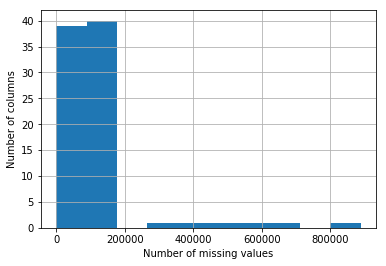

In [39]:
# Histogram showing number of missing values by number of columns
missing_col.hist()
plt.ylabel('Number of columns')
plt.xlabel('Number of missing values')
plt.show()

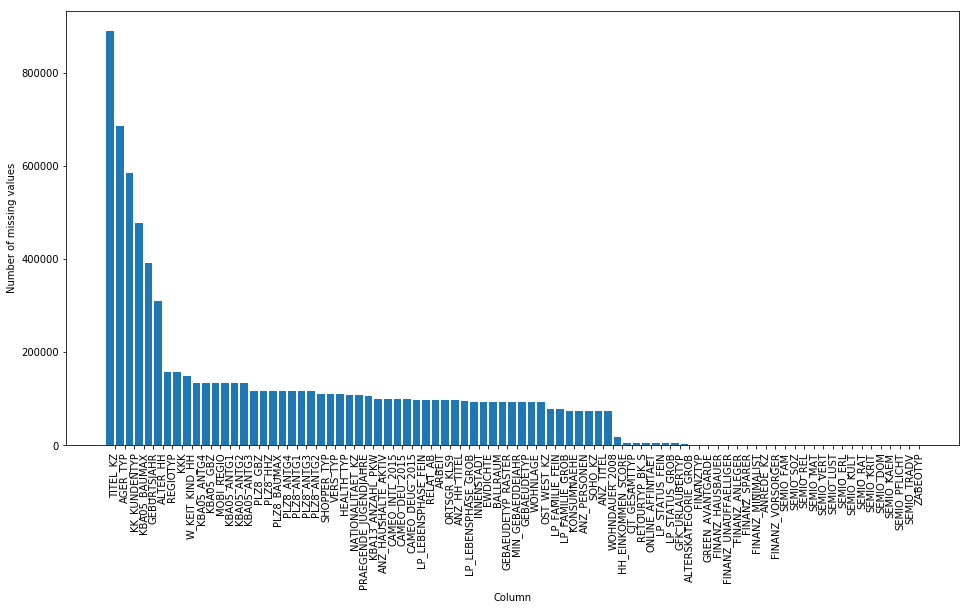

In [17]:
# Histogram of the distribution of sorted missing values by column name
missing_col_sorted = missing_col.sort_values(ascending=False)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(missing_col_sorted))+0.5,missing_col_sorted.index,rotation='vertical')
plt.ylabel('Number of missing values')
plt.bar(np.arange(len(missing_col_sorted)),missing_col_sorted)
plt.xlabel('Column')
plt.show()

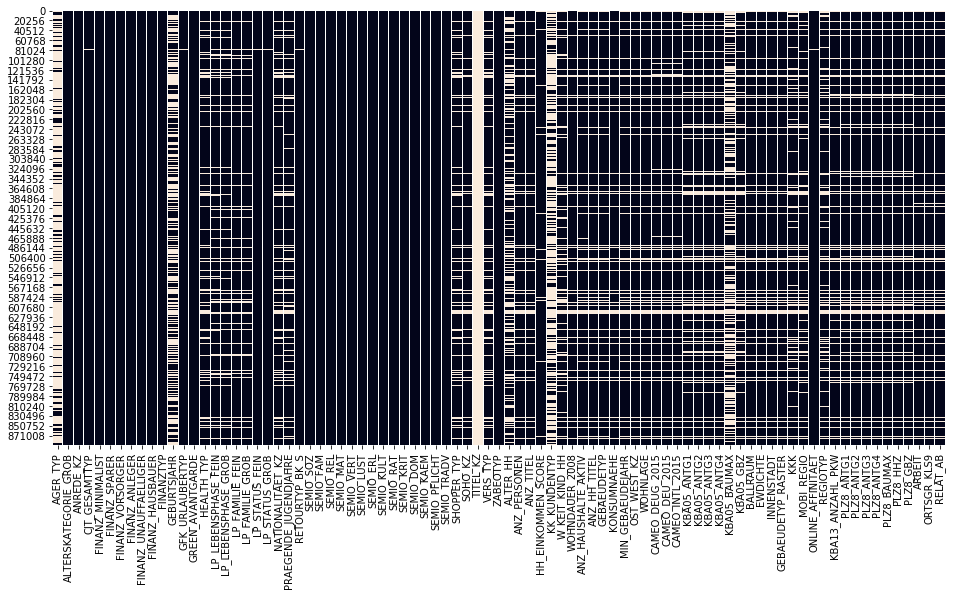

In [40]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize = (16,8))
sns.heatmap(azdias.isna(), cbar=False, xticklabels=True)
plt.show()

In [36]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Make list of columns with missing data greater than 25%
crit_cols = (missing_colpc > 0.25).tolist()
# Obtain name of attributes
drop_cols = feat_info[crit_cols]['attribute'].tolist()
# Drop unwanted columns
azdias = azdias.drop(drop_cols, axis = 1)

In [37]:
print('Dropped columns are: \n{}.'.format(drop_cols))
print('\nThere are {} rows and {} columns.'.format(azdias.shape[0],azdias.shape[1]))

Dropped columns are: 
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'].

There are 891221 rows and 79 columns.


#### Discussion 1.1.2: Assess Missing Data in Each Column

#### Columns dropped

Based on the histograms above, the majority of features have less than 200,000 missing values. Only a few of the features had more than 25% of the data missing. Using 25% as the cutoff, six features were dropped from the azdias dataset. They are:

TITEL_KZ (academic title flag)

AGER_TYP (best ager typology)

KK_KUNDENTYP (consumer pattern over past 12 months)

KBA05_BAUMAX (most common building type within the microcell)

GEBURTSJAHR  (year of birth)

ALTER_HH (birthdate of head of household)

#### Patterns observed

-  Features with the prefix "FINANZ" and "SEMIO" do not contain missing values. This is supported by the full black bars shown in the heatmap above. These features, which are grouped under person-level features, are ordinal types. 
-  The heatmap appears to exhibit patterns in the missing values (shown as pink lines) in the right half of the heatmap and for some of the features in the left half. This suggests that the missing values in the azdias dataset are not randomly distributed. 
- In general, if values are missing for one of the features of the same prefix, then the values in the rest of the features will also be missing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [38]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isna().sum(axis=1)
print(missing_row.sort_values(ascending=False))

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64


In [39]:
# Percentage of data with missing values by row. 
#Note that there are now 79 columns in azdias dataset. 
missing_rowpc = (azdias.isna().sum(axis=1)/azdias.shape[1]).sort_values(ascending = False)
print(missing_rowpc)

643174    0.620253
732775    0.620253
472919    0.607595
183108    0.594937
139316    0.594937
691141    0.594937
691142    0.594937
691171    0.594937
691183    0.594937
139332    0.594937
691197    0.594937
139323    0.594937
691212    0.594937
691122    0.594937
139267    0.594937
139255    0.594937
139250    0.594937
139248    0.594937
139245    0.594937
139243    0.594937
691317    0.594937
691129    0.594937
691118    0.594937
139236    0.594937
139478    0.594937
690871    0.594937
690876    0.594937
690878    0.594937
690887    0.594937
139521    0.594937
            ...   
540246    0.000000
540244    0.000000
540243    0.000000
540242    0.000000
540241    0.000000
540240    0.000000
540239    0.000000
540269    0.000000
540271    0.000000
540300    0.000000
540289    0.000000
540299    0.000000
540298    0.000000
540296    0.000000
540295    0.000000
540293    0.000000
540292    0.000000
540291    0.000000
540290    0.000000
540287    0.000000
540273    0.000000
540286    0.

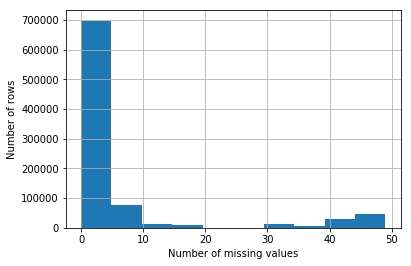

In [60]:
# Histogram showing distribution of number of missing values to number of rows
missing_row.hist()
plt.ylabel('Number of rows')
plt.xlabel('Number of missing values')
plt.show()

In [40]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# set threshold at 10
crit_row = missing_row <= 10
# Subset with low missing values by row
azdias_lowmv = azdias[crit_row]
print('Percentage of rows kept in subset with low to no missing values is {:.2f}%.'
      .format(azdias_lowmv.shape[0]/azdias.shape[0]*100))
# Subset with high missing values by row
azdias_highmv = azdias[~crit_row]

Percentage of rows kept in subset with low to no missing values is 87.54%.


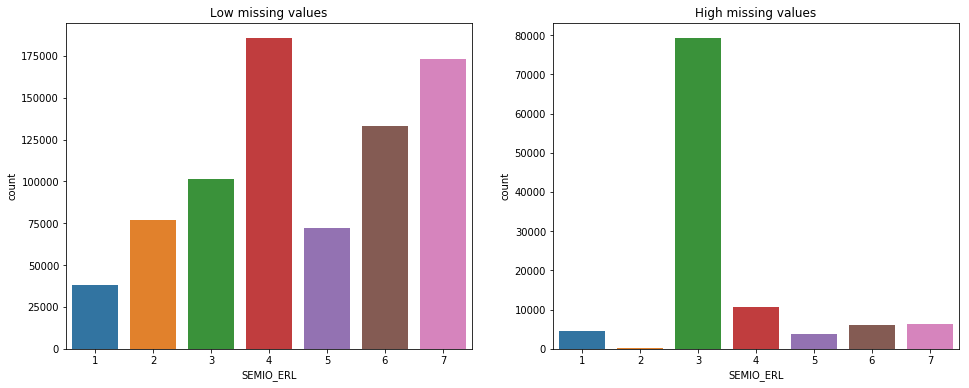

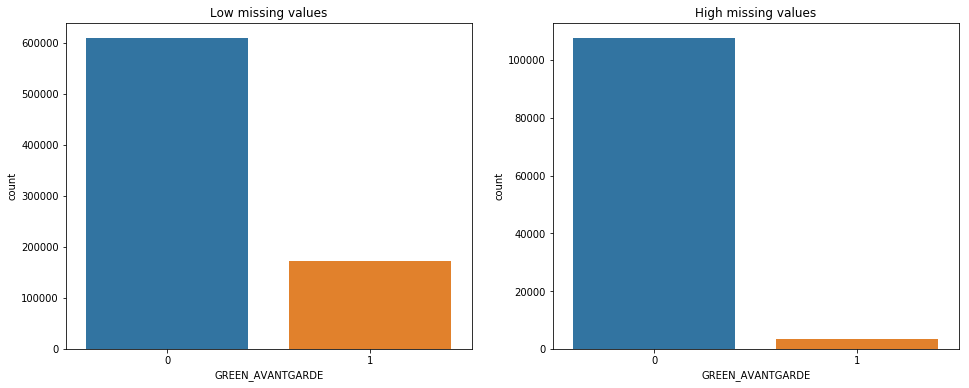

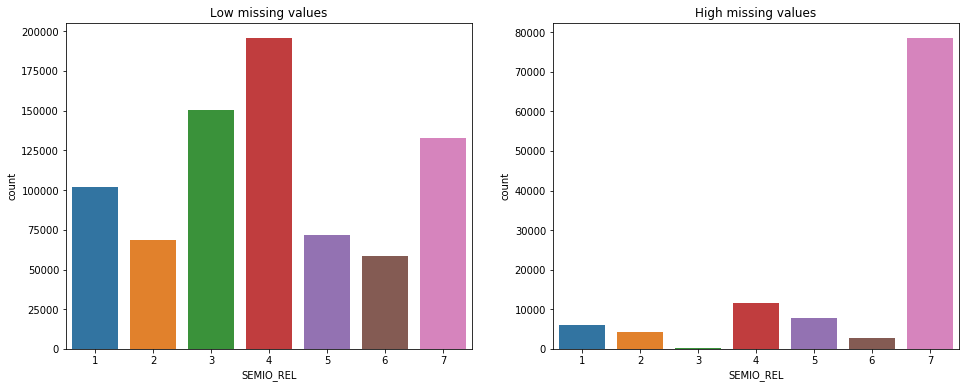

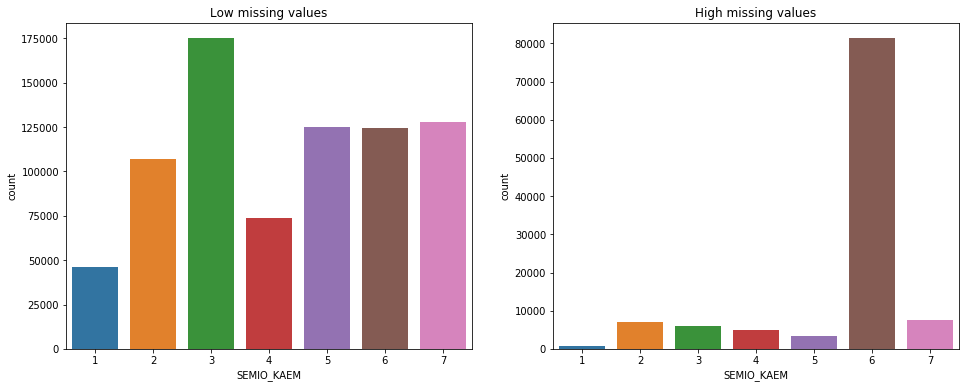

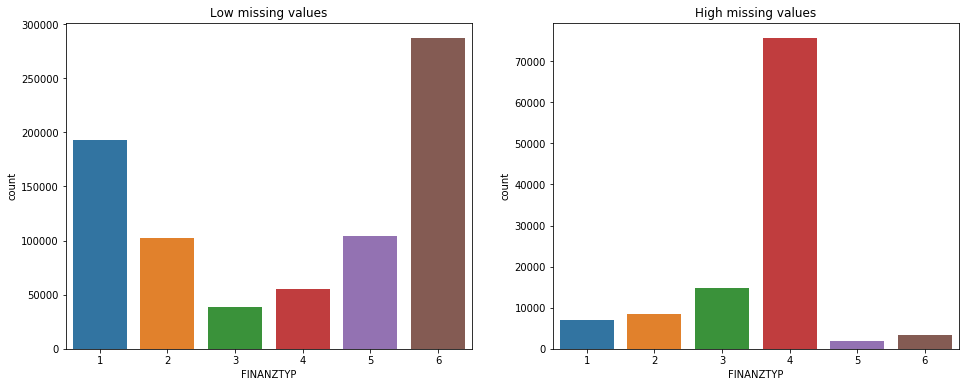

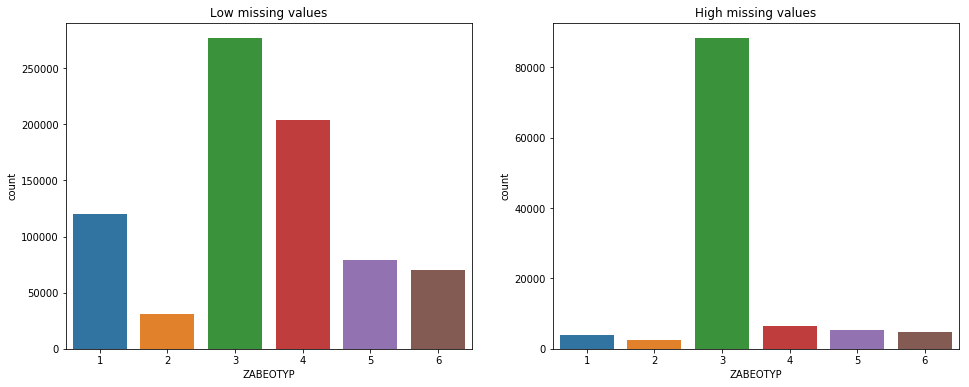

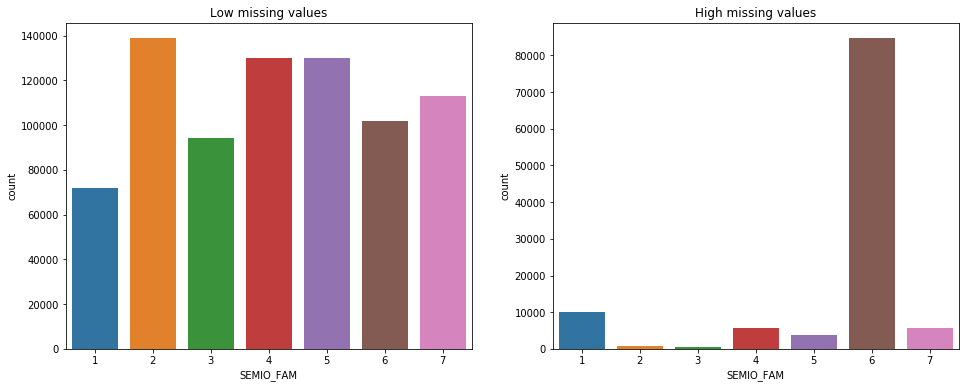

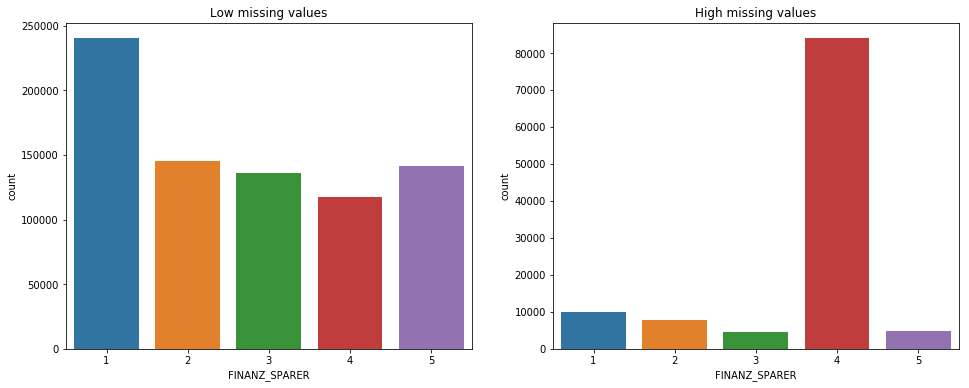

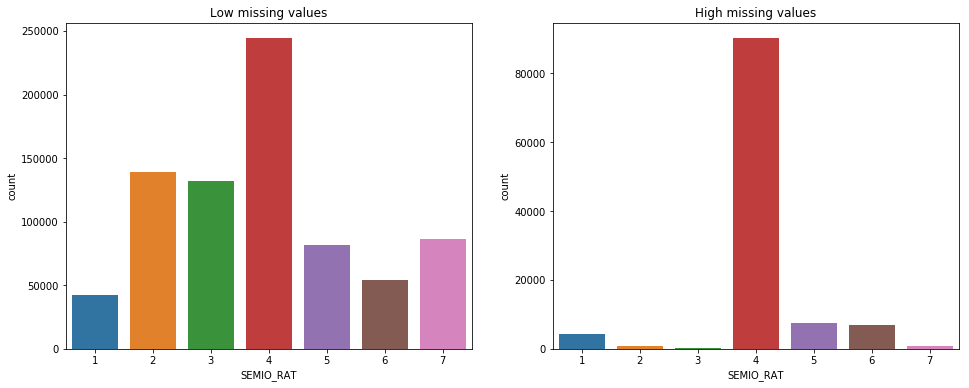

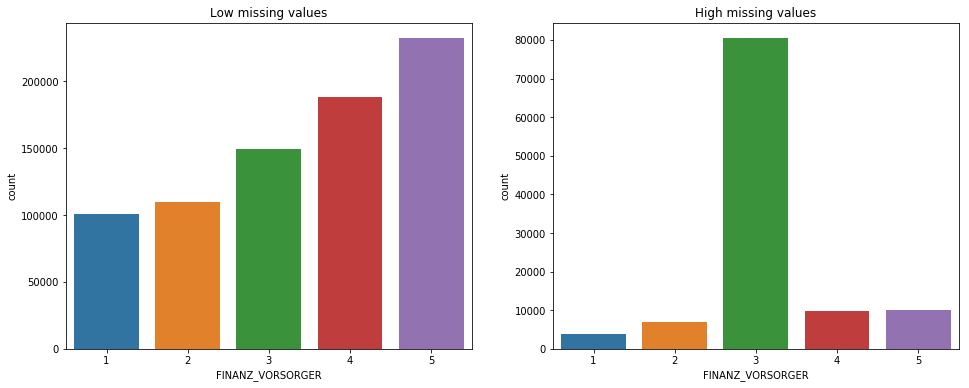

In [41]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Get sum of NaNs per column
new_missing_col = azdias.isna().sum() 
# Check which columns don't have missing values
criteria_col = np.array(new_missing_col == 0)
# Keep columns with no missing values for both subsets
azdias_lowmv_sbst = azdias_lowmv.loc[:,criteria_col]
azdias_highmv_sbst = azdias_highmv.loc[:,criteria_col]
# Randomly select 10 columns
random.seed(50)
rand_col = random.sample(list(azdias_lowmv_sbst.columns), 10)

for i in range(len(rand_col)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    sns.countplot(azdias_lowmv_sbst[rand_col[i]], ax=ax[0])
    ax[0].title.set_text('Low missing values')
    sns.countplot(azdias_highmv_sbst[rand_col[i]], ax=ax[1])
    ax[1].title.set_text('High missing values')
    fig.show()

In [42]:
# Create new variable of azdias dataset 
azdias_postmv = azdias_lowmv
# Get the number of rows and columns of new 
print('There are {} rows and {} columns.'.format(azdias_postmv.shape[0],azdias_postmv.shape[1]))

There are 780153 rows and 79 columns.


#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the histogram above, most of the rows have 10 or less missing values. By setting the threshold of missing values to less than or equal to 10, about 87.5% of the rows are kept. 

The distribution of data values of 10 randomly selected features (columns) with no missing data are qualitatively different between the two subsets. Subplots containing multi-level categories from the "high missing values" subset tend to display a single category significantly different from the other categories. The subplots of the "low missing values" subset, on the other hand, exhibit more variation in the distribution of categories. The qualitative difference between the two subsets may indicate participation bias. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
# How many features are there of each data type?

# Remove features that were removed from azdias dataframe
ft_lowmv = feat_info['attribute'].isin(drop_cols)
new_feat_info = feat_info[~ft_lowmv]
ind = pd.Index(new_feat_info['type']) # Convert to index
vals = ind.value_counts()
print(vals)

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter out attributes that are categorical
cat_list = new_feat_info[new_feat_info['type'] == 'categorical']['attribute']

# Use attribute list (cat_list) to get unique values of attributes in azdias_postmv
# Ignore NaN values
cat_unique = azdias_postmv[cat_list].apply(lambda x: [x[~x.isna()].unique()]) 
# Make a dataframe containing categorial attributes and their unique values
cat_table = pd.DataFrame(cat_unique).reset_index()
# Rename columns
cat_table.rename(columns = {"index": "attribute", 0: "unique_values"}, inplace = True)

# Define a function to mark encoding plan for each attribute
def enc_plan(df):
    '''
    This function returns the encoding plan based on categorial variable type. 
    Numeric binary variables are kept as is - "No change"
    Non-numeric binary variables are reencoded to a dummy variable - "Dummy variable"
    Multi-level variables are reencoded with OneHotEncoder - "OneHotEncoder" 
    
    Input: df (dataframe)
    Return: encoding plan (string)
    '''
    # multi-level 
    if len(df['unique_values'][0]) > 2:
        return 'OneHotEncoder'
    # binary
    elif len(df['unique_values'][0]) == 2:
        # get a binary value 
        val = df['unique_values'][0][0]
        # check if type of val is int or float
        if type(val) == type(1) or type(val) == type(1.0):
            return 'No change'
        else:
            return 'Dummy variable'    
    else:
        return 'Special'

# Add new column for the encoding plan
cat_table['encoding_plan'] = cat_table.apply(enc_plan, axis = 1)

In [45]:
cat_table

,attribute,unique_values,encoding_plan
0,ANREDE_KZ,"[[2, 1]]",No change
1,CJT_GESAMTTYP,"[[5.0, 3.0, 2.0, 4.0, 1.0, 6.0]]",OneHotEncoder
2,FINANZTYP,"[[1, 6, 5, 2, 4, 3]]",OneHotEncoder
3,GFK_URLAUBERTYP,"[[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4...",OneHotEncoder
4,GREEN_AVANTGARDE,"[[0, 1]]",No change
5,LP_FAMILIE_FEIN,"[[5.0, 1.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6....",OneHotEncoder
6,LP_FAMILIE_GROB,"[[3.0, 1.0, 5.0, 2.0, 4.0]]",OneHotEncoder
7,LP_STATUS_FEIN,"[[2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 5.0, 8.0, 6.0...",OneHotEncoder
8,LP_STATUS_GROB,"[[1.0, 2.0, 4.0, 5.0, 3.0]]",OneHotEncoder
9,NATIONALITAET_KZ,"[[1.0, 3.0, 2.0]]",OneHotEncoder


In [46]:
# Drop columns that have a condensed version 
col_drp = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'CAMEO_DEU_2015']  
azdias_postmv = azdias_postmv[azdias_postmv.columns.drop(col_drp)]
print('There are {} rows and {} columns.'.format(azdias_postmv.shape[0],azdias_postmv.shape[1]))

There are 780153 rows and 76 columns.


In [47]:
# Update cat_table by removing rows with 'LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'CAMEO_DEU_2015'
cat_table_upd = cat_table[~cat_table.attribute.isin(col_drp)]

In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Use 0, 1 for non-numeric binary attributes
dummy = cat_table_upd[cat_table_upd['encoding_plan'] == 'Dummy variable']['attribute']
azdias_postmv[dummy] = azdias_postmv[dummy].replace({'W': 0, 'O': 1})

# OneHotEncoder through pd.get_dummies for multi-level attributes
onehot = cat_table_upd[cat_table_upd['encoding_plan'] == 'OneHotEncoder']['attribute']
azdias_postmv = pd.get_dummies(azdias_postmv, columns = onehot)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [49]:
azdias_postmv.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

There were 18 categorical features after processing the missing values in the azdias dataset.
Of these 18 categorical features, 5 were binary and 13 were multi-level. 

Of the 13 categorical multi-level features, 3 were dropped to avoid adding too many columns if they were one-hot encoded. These 3 categories, all of which have condensed versions, are the following:  

LP_FAMILIE_FEIN   (Family type, fine scale)

LP_STATUS_FEIN   (Social status, fine scale)

CAMEO_DEU_2015   (German CAMEO: Wealth / Life Stage Typology, detailed scale)

The remaining 15 categorical features had the following done:

 - 4 numeric binary attributes were kept as is
 - 1 non-numeric binary attribute was reencoded using 0/1 to replace original values
 - 10 multi-level attributes were reencoded using one-hot encoding

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [106]:
# Determine which types in feat_info dataframe are mixed
mix_label = new_feat_info['type'] == 'mixed'
# Subset feat_info dataframe for only mixed attributes
feat_sbst_mix = new_feat_info[mix_label]
print(feat_sbst_mix)

                attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]


In [126]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Capture two dimensions: an interval-type variable for decade and a binary variable for movement.

"""
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
"""

# Separate decade by using a dict, key is original code, value is new code
# Example: 40s is represented by 1 and 2; Combine so that 40s is represented by 1 only.
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
# Create new attribute for decade
azdias_postmv["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_postmv["PRAEGENDE_JUGENDJAHRE"].replace(decade)

# Separate movements with mainstream as 0 and avantgarde as 1
movement = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
                 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
# Create new attribute for movement
azdias_postmv["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias_postmv["PRAEGENDE_JUGENDJAHRE"].replace(movement)

# Drop original mixed attribute PRAEGENDE_JUGENDJAHRE
azdias_postmv = azdias_postmv.drop("PRAEGENDE_JUGENDJAHRE", axis = 1)
print('There are {} rows and {} columns.'.format(azdias_postmv.shape[0],azdias_postmv.shape[1]))

There are 780153 rows and 130 columns.


In [127]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables
'''
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''
# Separate wealth using 'tens'-place 
wealth = {str(key):value for key,value in zip([i*10+j for i in range(1,6) for j in range(1,6)],
          sorted([1,2,3,4,5]*5))}
# Create new attribute for wealth
azdias_postmv["CAMEO_INTL_2015_WEALTH"] = azdias_postmv["CAMEO_INTL_2015"].replace(wealth)

# Separate life stage using 'ones'-place
life_stage = {str(key):value for key,value in zip([i*10+j for i in range(1,6) for j in range(1,6)],
             [1,2,3,4,5]*5)}
# Create new attribute for life stage
azdias_postmv["CAMEO_INTL_2015_LIFE_STAGE"] = azdias_postmv["CAMEO_INTL_2015"].replace(life_stage)

# Drop original mixed attribute CAMEO_INTL_2015
azdias_postmv = azdias_postmv.drop("CAMEO_INTL_2015", axis = 1)
print('There are {} rows and {} columns.'.format(azdias_postmv.shape[0],azdias_postmv.shape[1]))

There are 780153 rows and 131 columns.


In [30]:
# Investigate 'WOHNLAGE'
'''
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood
'''
azdias_postmv['WOHNLAGE'].value_counts()

3.0    246155
7.0    167130
4.0    134022
2.0     98784
5.0     72899
1.0     43191
8.0     15018
0.0      2954
Name: WOHNLAGE, dtype: int64

In [128]:
# Drop other mixed columns
col_mixdrp = ['PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE']
azdias_postmv = azdias_postmv[azdias_postmv.columns.drop(col_mixdrp)]

In [129]:
azdias_postmv.shape

(780153, 127)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Of the 6 mixed features, "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were kept. These were engineered to create new variables, two for "PRAEGENDE_JUGENDJAHRE" and two for "CAMEO_INTL_2015".  

The remaining 4 mixed features were dropped. They are:

PLZ8_BAUMAX  (Most common building type within the PLZ8 region)

LP_LEBENSPHASE_FEIN  (Life stage, fine scale)   

LP_LEBENSPHASE_GROB  (Life stage, gross scale)

WOHNLAGE (Neighborhood quality (or rural flag))

Both "LP_LEBENSPHASE_GROB" and "LP_LEBENSPHASE_FEIN" combine information on three axes: family type, social status, and age. Since all three axes are covered in other features, one can assume dropping these mixed features will not affect the analysis. "PLZ8_BAUMAX" also contains information that is covered by other features with the prefix "PLZ8", so it was dropped as well. 

"WOHNLAGE" contains both neighborhood quality (ranging from very good to very poor) and rural flags ("rural neighborhood" and "new building in rural neighborhood"). Since it appears that neighborhood quality was not scored for rural neighborhoods, one could engineer the rural flags to 0 or "no score calculated". However, this would significantly change the count value for "no score calculated" from 2954 (0.37%) to 185102 (23.7%). Additionally, "no score calculated" indicates missing or unknown data. Lastly, other features contain information related to neighborhood quality and neighborhood density. As a result, "WOHNLAGE" was dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

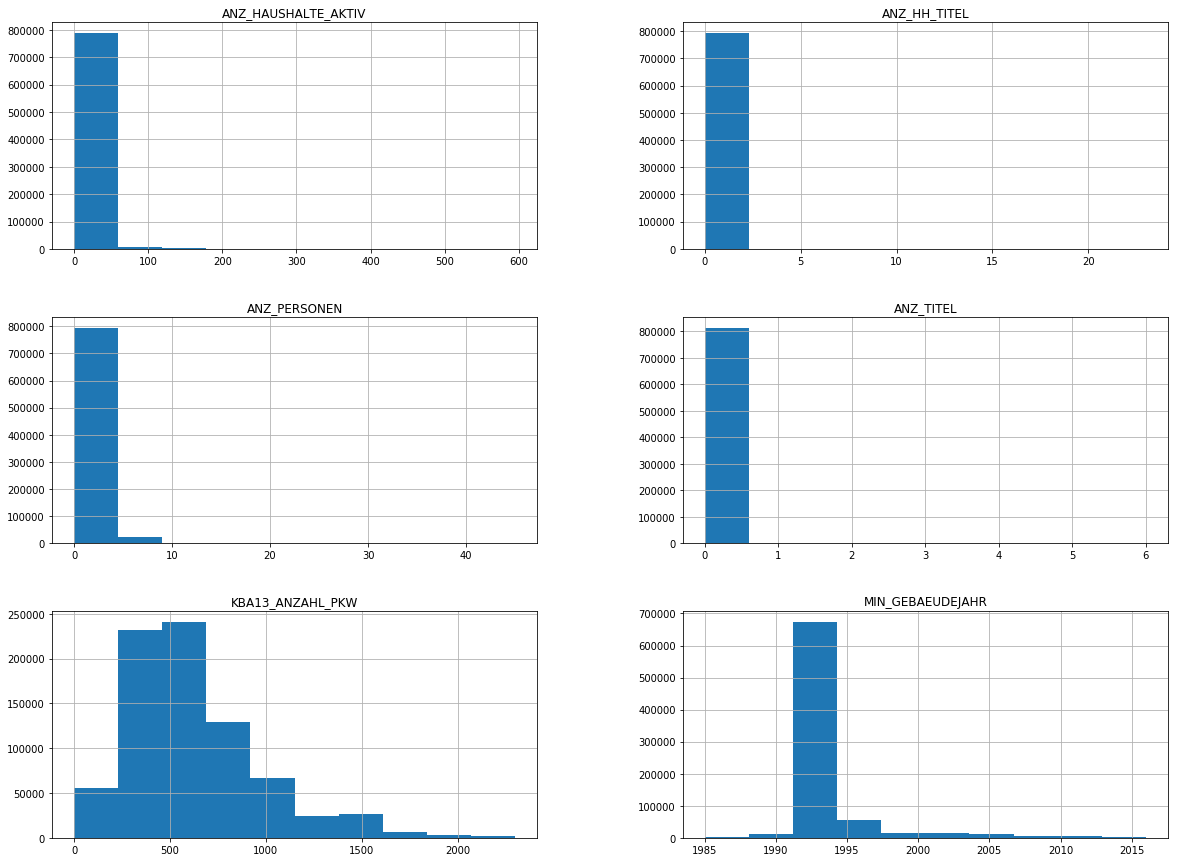

In [4]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Check for skewed numeric features

# Determine which types in feat_info are numeric
numeric_label = feat_info['type'] == 'numeric'
num_feat = feat_info[numeric_label.tolist()].attribute.tolist()
# Remove column with high percentage of missing values
num_feat.remove('GEBURTSJAHR')
# Subset azdias data to contain just these columns
azdias_num = azdias[num_feat]
# Make histograms for each column
azdias_num.hist(bins=10, figsize=(20,15))
plt.show()

In [5]:
azdias_num.describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,817722.000000,817722.000000,798073.000000,794213.000000,798073.000000,785421.000000
mean,1.727637,0.004162,8.287263,0.040647,1993.277011,619.701439
std,1.155849,0.068855,15.628087,0.324028,3.332739,340.034318
min,0.000000,0.000000,0.000000,0.000000,1985.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1992.000000,384.000000
50%,1.000000,0.000000,4.000000,0.000000,1992.000000,549.000000
75%,2.000000,0.000000,9.000000,0.000000,1993.000000,778.000000
max,45.000000,6.000000,595.000000,23.000000,2016.000000,2300.000000


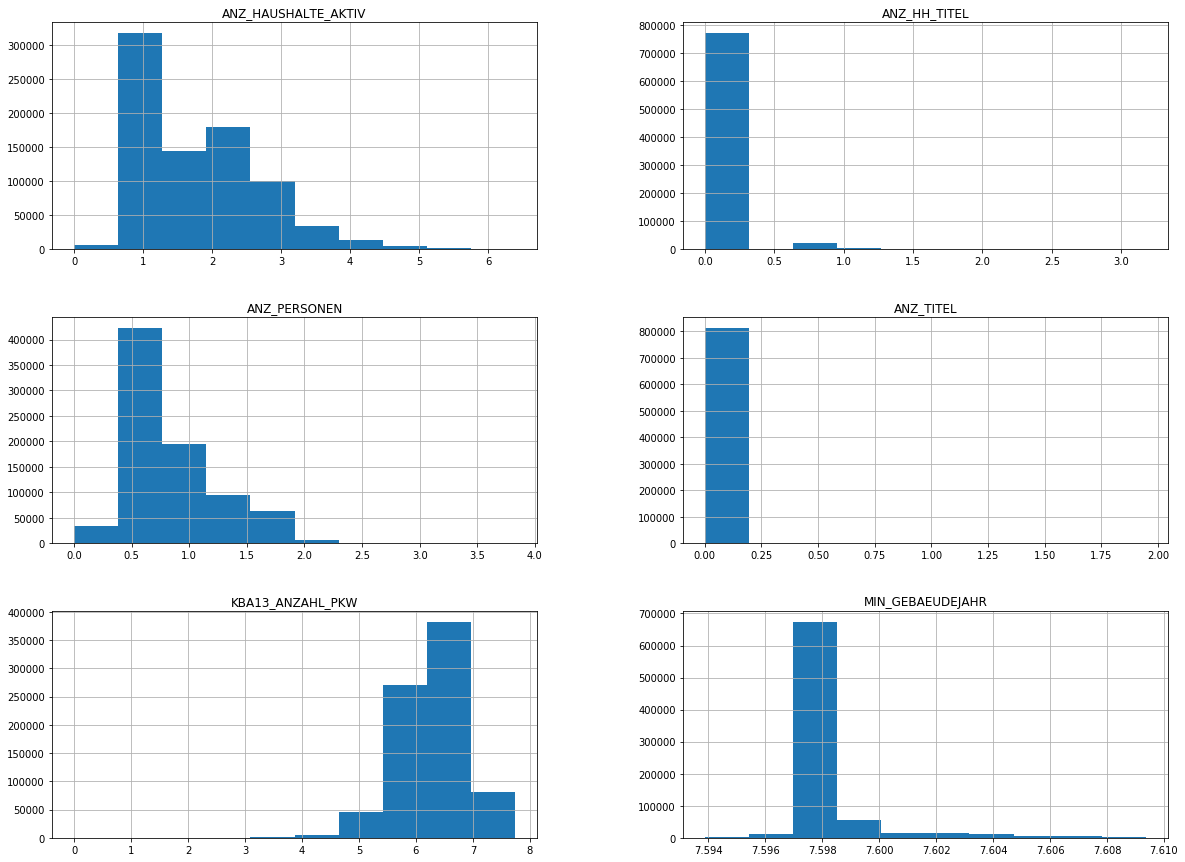

In [6]:
# Log-transform the skewed features, apply to all 6 numeric features
azdias_log = pd.DataFrame(data = azdias)
azdias_log[num_feat] = azdias[num_feat].apply(lambda x: np.log(x + 1))
# Subset azdias data to contain just these columns
azdias_log_num = azdias[num_feat]
# Make histograms for each column
azdias_log_num.hist(bins=10, figsize=(20,15))
plt.show()

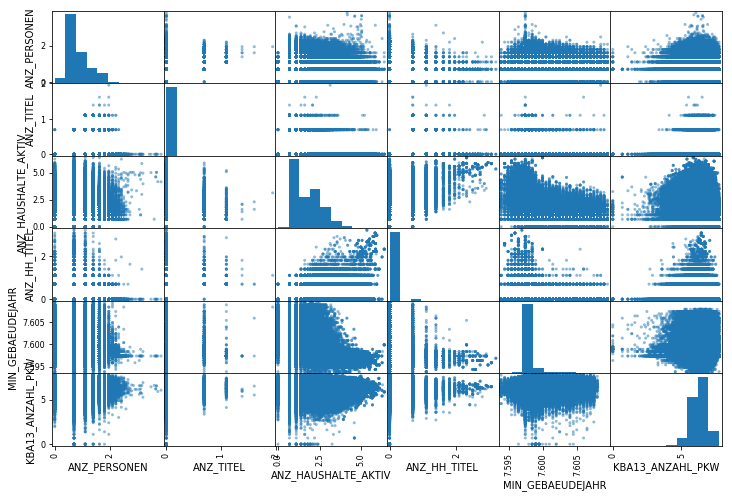

In [9]:
# Check for correlations among the numeric features, ignore ordinal and interval types
# Use scatter matrix to visualize any correlations
pd.plotting.scatter_matrix(azdias_log_num, figsize=(12,8))
plt.show()

In [10]:
# Compute correlations between features
corr_matrix = azdias_log_num.corr()
corr_matrix

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
ANZ_PERSONEN,1.000000,0.027416,-0.236098,-0.043154,0.037001,0.050184
ANZ_TITEL,0.027416,1.000000,-0.009588,0.321386,-0.002266,0.000847
ANZ_HAUSHALTE_AKTIV,-0.236098,-0.009588,1.000000,0.224976,-0.209430,-0.131689
ANZ_HH_TITEL,-0.043154,0.321386,0.224976,1.000000,-0.043396,-0.034540
MIN_GEBAEUDEJAHR,0.037001,-0.002266,-0.209430,-0.043396,1.000000,0.024537
KBA13_ANZAHL_PKW,0.050184,0.000847,-0.131689,-0.034540,0.024537,1.000000


In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


#### Discussion 1.2.3: Complete Feature Selection

Numeric type features were graphed to check if any of these features exhibit skewness. Since some of the features appeared skewed in the plots above, log transformation was performed on all the numeric type features (6 in total). In addition, correlations between numeric type features were assessed. No significant correlations were found. 

Even though log transformation was applied above, this step was not added to the cleaning function below since feature scaling will be performed. 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [16]:
def clean_data(df, ft_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame (df), Feature Summary Table DataFrame (ft_info)
    OUTPUT: Trimmed and cleaned demographics DataFrame with and without encoding (df and df_noenc)
    """    
    # Put in code here to execute all main cleaning steps:
    
    ##### convert missing value codes into NaNs, ... #####
    
    for i in range(0,df.shape[1]):
        # Get data type for column
        data_type = df.dtypes[i]
        # Obtain missing/unknown values for column from feat_info dataframe
        values = ft_info['missing_or_unknown'][i] 
        # Parse values
        unknown = values[1:-1].split(',')
        # Skip empty strings
        if unknown[0] is not '':
            # Loop through all values, converting values to correct data type
            for x in unknown:
                if data_type == 'float64':
                    df[df.columns[i]].replace(float(x), np.nan, inplace=True)
                elif data_type == 'int64':
                    df[df.columns[i]].replace(int(x), np.nan, inplace=True)
                else: 
                    df[df.columns[i]].replace(x, np.nan, inplace=True)
        else:
            continue
    
    ##### remove selected columns and rows, ...#####
    
    # Drop columns with high number of missing values
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH',
                 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(drop_cols, axis = 1)     
    
    # Get missing values by row
    missing_row = df.isna().sum(axis=1)
    # set threshold at 10
    crit_row = missing_row <= 10
    # Subset df with rows with 10 or less missing values
    df_lowmv = df[crit_row]  

    # Other columns to be removed
    cols_drops = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN', 
                 'CAMEO_DEU_2015', 'PLZ8_BAUMAX',
                 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
                 'WOHNLAGE'] 
    df_lowmv = df_lowmv.drop(cols_drops, axis = 1) 
    
    ##### select, re-encode, and engineer column values.#####
    
    ### Engineer mixed-type features ###
    
    ## Engineer two new variables for "PRAEGENDE_JUGENDJAHRE" ##
    
    # Separate decade 
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    # Create new attribute for decade
    df_lowmv["PRAEGENDE_JUGENDJAHRE_DECADE"] = df_lowmv["PRAEGENDE_JUGENDJAHRE"].replace(decade)

    # Separate movements with mainstream as 0 and avantgarde as 1
    movement = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
                     2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
    # Create new attribute for movement
    df_lowmv["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df_lowmv["PRAEGENDE_JUGENDJAHRE"].replace(movement)

    # Drop original mixed attribute PRAEGENDE_JUGENDJAHRE
    df_lowmv = df_lowmv.drop("PRAEGENDE_JUGENDJAHRE", axis = 1)    
    
    ## Engineer two new variables for "CAMEO_INTL_2015" ##
    
    # Separate wealth using 'tens'-place 
    wealth = {str(key):value for key,value in zip([i*10+j for i in range(1,6) for j in range(1,6)],
              sorted([1,2,3,4,5]*5))}
    # Create new attribute for wealth
    df_lowmv["CAMEO_INTL_2015_WEALTH"] = df_lowmv["CAMEO_INTL_2015"].replace(wealth)

    # Separate life stage using 'ones'-place
    life_stage = {str(key):value for key,value in zip([i*10+j for i in range(1,6) for j in range(1,6)],
                  [1,2,3,4,5]*5)}
    # Create new attribute for life stage
    df_lowmv["CAMEO_INTL_2015_LIFE_STAGE"] = df_lowmv["CAMEO_INTL_2015"].replace(life_stage)

    # Drop original mixed attribute CAMEO_INTL_2015
    df_lowmv = df_lowmv.drop("CAMEO_INTL_2015", axis = 1)       

    # Save df without encoding
    df_noenc = df_lowmv
    
    ### Re-encode categorical features ###
    
    ## Use 0, 1 for non-numeric binary attribute ##
    df_lowmv["OST_WEST_KZ"] = df_lowmv["OST_WEST_KZ"].replace({'W': 0, 'O': 1})
    
    ## One-hot encoding for multi-level attributes ##
    onehot = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
              'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
              'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP','CAMEO_DEUG_2015']
    df = pd.get_dummies(df_lowmv, columns = onehot)

    # Return the cleaned dataframe and dataframe without encoding
    return df, df_noenc   

In [17]:
azdias_cleaned, azdias_noenc = clean_data(azdias,feat_info)
# Get the number of rows and columns of azdias dataset
print('There are {} rows and {} columns.'.format(azdias_cleaned.shape[0],azdias_cleaned.shape[1]))

There are 780153 rows and 127 columns.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

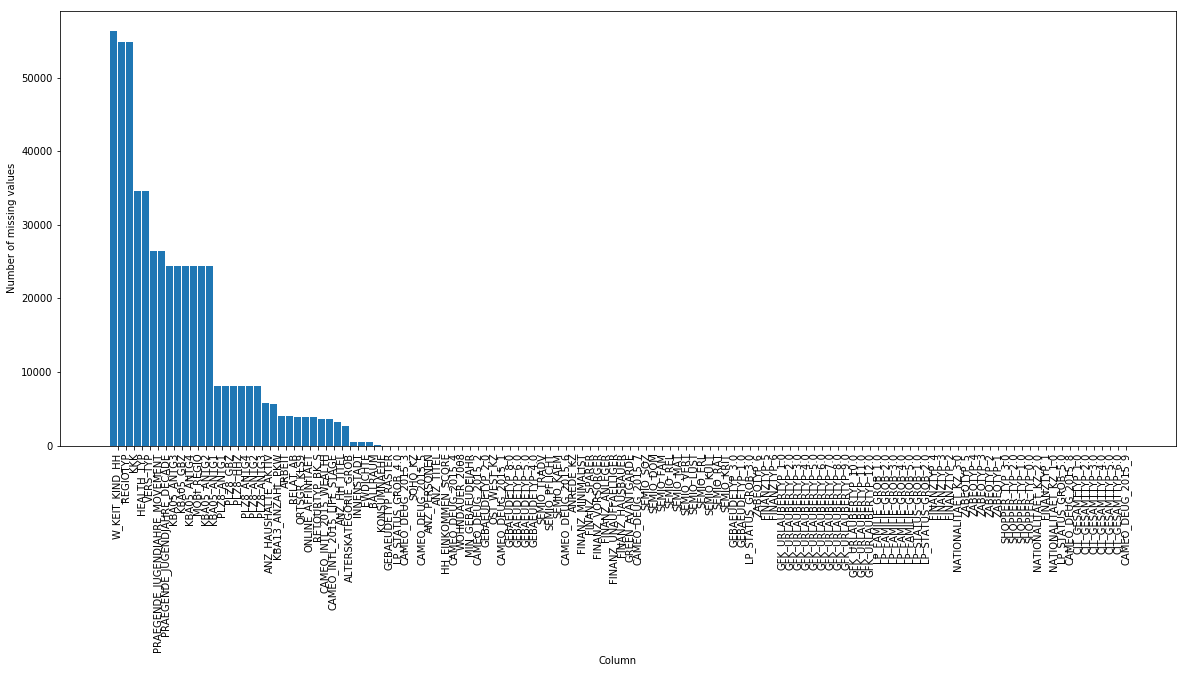

In [18]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Total missing values by column
missing_cols = azdias_cleaned.isna().sum()

# Histogram of the distribution of sorted missing values by column name
missing_cols_sorted = missing_cols.sort_values(ascending=False)
plt.figure(figsize=(20,8))
plt.xticks(np.arange(len(missing_cols_sorted))+0.5,missing_cols_sorted.index,rotation='vertical')
plt.ylabel('Number of missing values')
plt.bar(np.arange(len(missing_cols_sorted)),missing_cols_sorted)
plt.xlabel('Column')
plt.show()

In [19]:
# Columns containing missing values
feat_miss = missing_cols[missing_cols != 0]
# Make a dataframe containing attribute and number of missing values
feat_miss_table = pd.DataFrame(feat_miss).reset_index()
# Rename columns
feat_miss_table.rename(columns = {"index": "attribute", 0: "number_missing"}, inplace = True) 
feat_miss_table = feat_miss_table.merge(feat_info, on='attribute', how='left').drop(['information_level', 'missing_or_unknown'], axis=1)


# PRAEGENDE_JUGENDJAHRE_DECADE
feat_miss_table.iat[31,2] = 'interval'
# PRAEGENDE_JUGENDJAHRE_MOVEMENT 
feat_miss_table.iat[32,2] = 'categorical'
# CAMEO_INTL_2015_WEALTH 
feat_miss_table.iat[33,2] = 'ordinal'
# CAMEO_INTL_2015_LIFE_STAGE
feat_miss_table.iat[34,2] = 'ordinal'

print(feat_miss_table)

                         attribute  number_missing         type
0             ALTERSKATEGORIE_GROB            2625      ordinal
1                       HEALTH_TYP           34524      ordinal
2                   RETOURTYP_BK_S            3834      ordinal
3                         VERS_TYP           34524  categorical
4                   W_KEIT_KIND_HH           56282      ordinal
5              ANZ_HAUSHALTE_AKTIV            5740      numeric
6                     ANZ_HH_TITEL            3233      numeric
7                      KONSUMNAEHE              51      ordinal
8                      KBA05_ANTG1           24457      ordinal
9                      KBA05_ANTG2           24457      ordinal
10                     KBA05_ANTG3           24457      ordinal
11                     KBA05_ANTG4           24457      ordinal
12                       KBA05_GBZ           24457      ordinal
13                        BALLRAUM             543      ordinal
14                        EWDICHTE      

In [20]:
# Get list of missing categorical attributes
cat = feat_miss_table['type']=='categorical'
cat_type = feat_miss_table[cat.tolist()].attribute.tolist()
# Get list of missing non-categorical attributes
non_cat = feat_miss_table['type']!='categorical'
non_cat_type = feat_miss_table[non_cat.tolist()].attribute.tolist()

In [21]:
# Create new variable
azdias_nonan = azdias_cleaned

# Use mean imputation on ordinal, interval, and ordinal types
imp_mean = Imputer(missing_values= np.nan, strategy='mean', axis=0)
azdias_nonan[non_cat_type] = imp_mean.fit_transform(azdias_nonan[non_cat_type])

# Use mode imputation on categorial type
imp_mode = Imputer(missing_values= np.nan, strategy='most_frequent', axis=0)
azdias_nonan[cat_type] = imp_mode.fit_transform(azdias_nonan[cat_type])

# Check that all missing values are transformed
print('There are {} missing values.'.format(azdias_nonan.isnull().sum().sum()))

There are 0 missing values.


In [22]:
# Apply feature scaling
ss = StandardScaler()
# Scaled with no missing data
azdias_scaled = ss.fit_transform(azdias_nonan)
azdias_scaled

array([[-1.76709921,  0.95839484, -1.48813986, ..., -0.33043385,
         2.20223657, -0.3993372 ],
       [ 0.19877074,  0.95839484, -1.48813986, ..., -0.33043385,
        -0.45408382, -0.3993372 ],
       [ 1.18170571,  0.95839484,  0.68892835, ..., -0.33043385,
        -0.45408382, -0.3993372 ],
       ..., 
       [-0.78416424,  0.95839484, -0.76245046, ..., -0.33043385,
        -0.45408382, -0.3993372 ],
       [-1.76709921, -1.04341129, -1.48813986, ..., -0.33043385,
        -0.45408382,  2.5041494 ],
       [ 1.18170571, -1.04341129,  0.68892835, ..., -0.33043385,
        -0.45408382, -0.3993372 ]])

### Discussion 2.1: Apply Feature Scaling

There were 33 (out of 127) features that still contained missing data. If one were to remove the rows containing missing data, about 7% of the data would be removed in addition to what was removed earlier in this project. To retain all the data, mean imputation was applied to ordinal, interval, and numeric types. Mode or most frequent imputation was applied to categorical type features. It's important to keep in mind that using these methods may introduce bias in the data. Lastly, standardization was applied to the entire dataset regardless of feature type. In the future, it may be worth checking to see if not standardizing the categorical features will affect the analysis. 

Of note, one can use StandardScaler() on datasets with missing data. However, for this project, azdias_scaled, was considered for further analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [11]:
# Apply PCA to the data.

# Set pca
pca = PCA()  

# Do PCA
azdias_pca = pca.fit_transform(azdias_scaled)

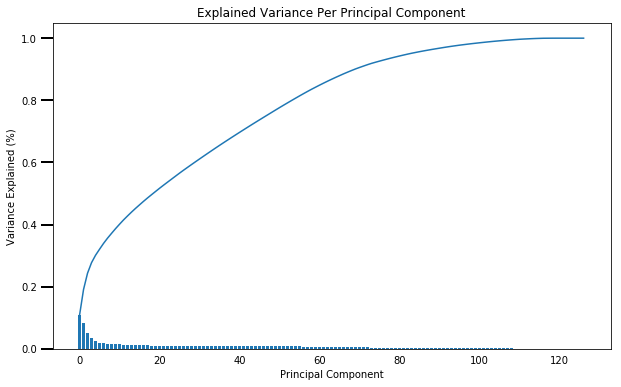

In [12]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca
            
    OUTPUT: None
            
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

# Call the function to create scree plot on data
scree_plot(pca)

In [13]:
# Determine number of components to explain more than 95% of the variability in the original data
var = []
for i, j in enumerate(pca.explained_variance_ratio_):
    if np.sum(var) <= 0.95:
        var.append(j)
    else:
        print("Using {} components, we can explain {:.2f}% of the variability in the original data.".format(i, np.sum(var)*100))
        break 

Using 84 components, we can explain 95.14% of the variability in the original data.


In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(84)
azdias_pca_final = pca.fit_transform(azdias_scaled)

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
print('The amount of variability explained by the first component is {:.2f}.'.format(ratios[0][0]))
print('The amount of variability explained by the second component is {:.2f}.'.format(ratios[1][0]))
print('The amount of variability explained by the third component is {:.2f}.'.format(ratios[2][0]))

The amount of variability explained by the first component is 0.11.
The amount of variability explained by the second component is 0.08.
The amount of variability explained by the third component is 0.05.


### Discussion 2.2: Perform Dimensionality Reduction

The number of principal components that will be retained for the next step of the analysis and which explain at least 95% of the variability in the dataset is 84.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(df, pca, nth_component):
    '''
    Create a DataFrame of the PCA results for the nth component 

    INPUT: pca: PCA result
           df: original dataset (dataframe)
           nth_component: nth principal component
           
    OUTPUT: 
           components = dataframe of weights corresponding to features, sorted by weight
    '''
    # PCA components
    components = pd.DataFrame(np.round(pca.components_[nth_component-1], 4), index=df.columns)
    components.rename(columns = {0: 'PCA-{}'.format(nth_component)}, inplace = True)
    components = components.sort_values(by='PCA-{}'.format(nth_component),ascending = False)
    
    return components

# The first principal component
pca_results(azdias_nonan, pca, 1)

,PCA-1
LP_STATUS_GROB_1.0,0.1999
HH_EINKOMMEN_SCORE,0.1889
PLZ8_ANTG3,0.1887
CAMEO_INTL_2015_WEALTH,0.1863
PLZ8_ANTG4,0.1831
ORTSGR_KLS9,0.1611
EWDICHTE,0.1597
FINANZ_HAUSBAUER,0.1465
FINANZ_SPARER,0.1439
FINANZTYP_1,0.1316


In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_nonan, pca, 2)

,PCA-2
ALTERSKATEGORIE_GROB,0.2269
FINANZ_VORSORGER,0.2113
ZABEOTYP_3,0.2043
SEMIO_ERL,0.1873
SEMIO_LUST,0.1601
RETOURTYP_BK_S,0.1545
W_KEIT_KIND_HH,0.1263
FINANZ_HAUSBAUER,0.1134
CJT_GESAMTTYP_2.0,0.1052
FINANZTYP_5,0.0951


In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_nonan, pca, 3)

,PCA-3
SEMIO_VERT,0.3259
SEMIO_SOZ,0.2586
SEMIO_FAM,0.2578
SEMIO_KULT,0.2456
FINANZTYP_5,0.1398
FINANZ_MINIMALIST,0.1322
SHOPPER_TYP_0.0,0.1269
ZABEOTYP_1,0.1088
SEMIO_REL,0.1016
RETOURTYP_BK_S,0.0864


### Discussion 2.3: Interpret Principal Components


Below are the top positive and negative weights for the first three principal components.

PCA-1
 - LP_STATUS_GROB_1.0	&emsp;__0.1999__
 - HH_EINKOMMEN_SCORE	&emsp;__0.1889__ 
 - FINANZ_MINIMALIST  &emsp; __-0.2085__
 - MOBI_REGIO	      &emsp; __-0.2104__
 
The top positive weights for the first principal component include income-type features, LP_STATUS_GROB_1.0 (low income earners) and HH_EINKOMMEN_SCORE (estimated household net income). The top negative weights are MOBI_REGIO (a region's movement patterns) and FINANZ_MINIMALIST (financial type - low interest). 

PCA-2

 - ALTERSKATEGORIE_GROB	&emsp;__0.2269__
 - FINANZ_VORSORGER	   &emsp; __0.2113__
 - SEMIO_REL	      &emsp; __-0.2136__
 - PRAEGENDE_JUGENDJAHRE_DECADE	&emsp;__-0.2305__

In the second principal component, the largest positive and negative associations are with age, ALTERSKATEGORIE_GROB 
and PRAEGENDE_JUGENDJAHRE_DECADE, respectively. These age-related features are followed by positively weighed FINANZ_VORSORGER (finance type: be prepared) and negatively weighed SEMIO_REL (religious personality).

PCA-3

- SEMIO_VERT	&emsp;__0.3259__
- SEMIO_SOZ	&emsp;__0.2586__
- SEMIO_FAM	&emsp;__0.2578__
- SEMIO_DOM	&emsp;__-0.2950__
- SEMIO_KAEM	&emsp;__-0.3236__
- ANREDE_KZ	&emsp;__-0.3518__

The top three largest weights, both positive and negative, of the third principal component are primarily related to personality typology and gender. ANREDE_KZ (gender) has the largest negative weight, and SEMIO_VERT (dreamful personality) has the largest positive weight. Interestingly, aggressive-type personalities, SEMIO_KAEM and SEMIO_DOM, group together while considerate-type personalities, SEMIO_SOZ and SEMIO_FAM, cluster together. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...     
# compute the average within-cluster distances.

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    seed = np.random.RandomState(15)
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state = seed)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
 
# Obtain list of scores on range of centers
scores = []
centers = list(range(1, 30))
for center in centers:
    print(center)
    scores.append(get_kmeans_score(azdias_pca_final, center))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


<IPython.core.display.Javascript object>


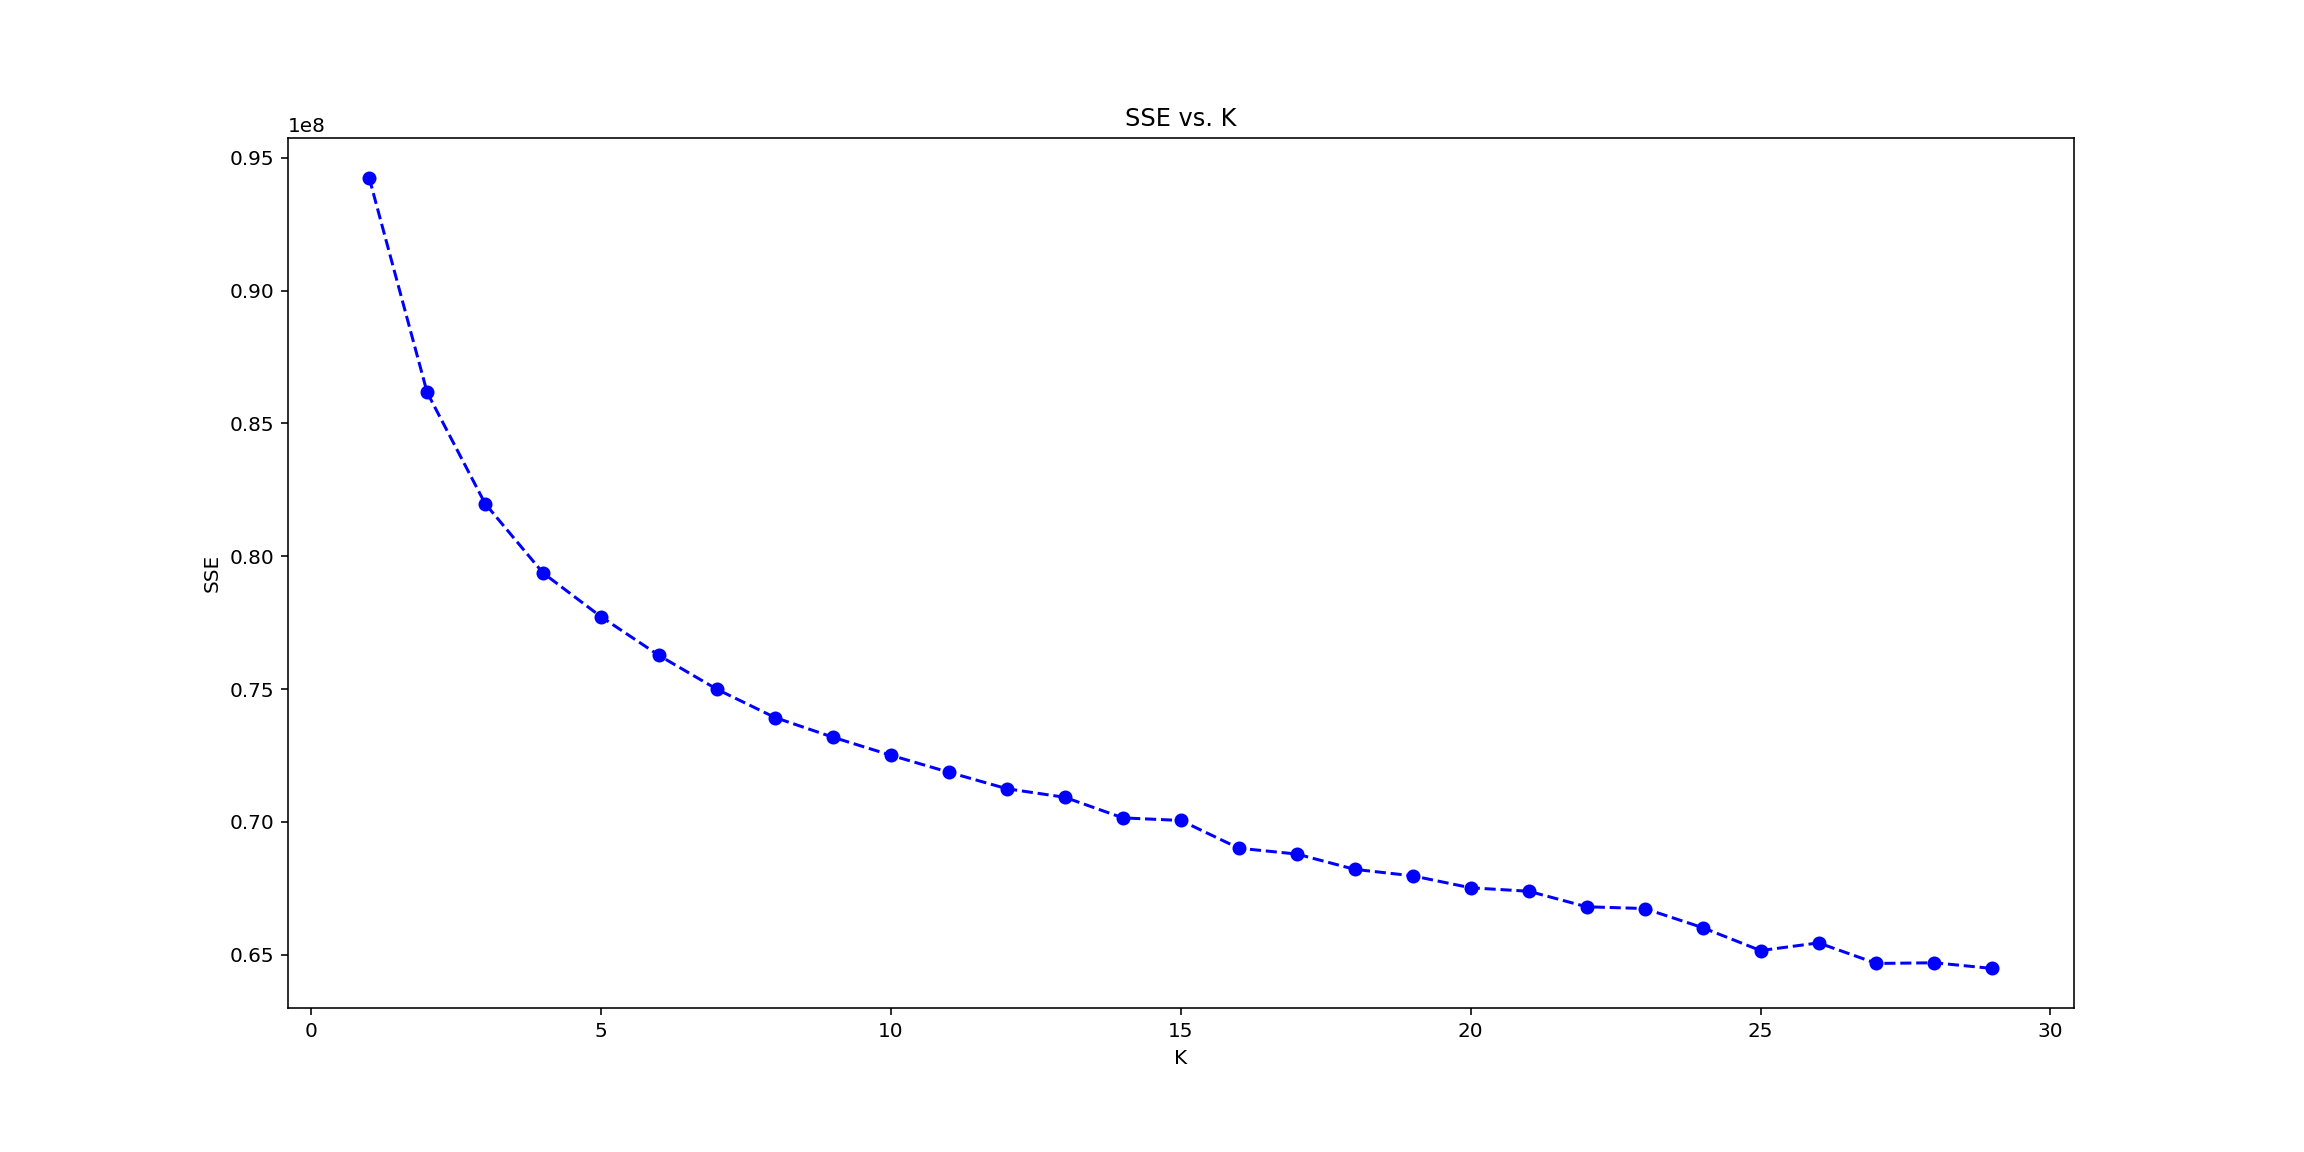

In [72]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
%matplotlib notebook
plt.figure(figsize=(16, 8))
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.show()

In [24]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
seed = np.random.RandomState(15)
kmeans = KMeans(n_clusters = 14, random_state = seed)
model = kmeans.fit(azdias_pca_final)
predictions_gen = model.predict(azdias_pca_final)

### Discussion 3.1: Apply Clustering to General Population

After zooming in on the plot of the kmeans results from 1 to 29, cluster 14 appears to be the best option for segmenting the population. Prior to cluster 14, the graph shows a steady decline. Then from cluster 14 to 15, the graph seems to plateau. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [25]:
# Load in the customer demographics data.
customers = customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")

In [26]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

##### Preprocessing
customers_cleaned, customers_noenc = clean_data(customers, feat_info)
# Check number of columns
if customers_cleaned.shape[1] != 127:
    # Find different columns
    diff_cols =set(azdias_cleaned.columns).difference(set(customers_cleaned.columns))
    # Add column and set all values to 0
    for column in diff_cols:
        customers_cleaned[column] = 0

##### Feature Transformation

# Fill in missing values

# Total missing values by column
columns_nan = customers_cleaned.isna().sum()
# Features containing missing values
feat_miss_cust = columns_nan[columns_nan != 0]
# Make a dataframe containing attribute and number of missing values
feat_miss_cust_table = pd.DataFrame(feat_miss_cust).reset_index()
# Rename columns
feat_miss_cust_table.rename(columns = {"index": "attribute", 0: "number_missing"}, inplace = True) 
feat_miss_cust_table = feat_miss_cust_table.merge(feat_info, on='attribute', how='left').drop(['information_level', 'missing_or_unknown'], axis=1)

# Add the following columns and type
# PRAEGENDE_JUGENDJAHRE_DECADE
feat_miss_cust_table.iat[30,2] = 'interval'
# PRAEGENDE_JUGENDJAHRE_MOVEMENT 
feat_miss_cust_table.iat[31,2] = 'categorical'
# CAMEO_INTL_2015_WEALTH 
feat_miss_cust_table.iat[32,2] = 'ordinal'
# CAMEO_INTL_2015_LIFE_STAGE
feat_miss_cust_table.iat[33,2] = 'ordinal'

print(feat_miss_cust_table)

# Get list of missing categorical attributes
cust_cat = feat_miss_cust_table['type']=='categorical'
cust_cat_type = feat_miss_cust_table[cust_cat.tolist()].attribute.tolist()
# Get list of missing non-categorical attributes
cust_non_cat = feat_miss_cust_table['type']!='categorical'
cust_non_cat_type = feat_miss_cust_table[cust_non_cat.tolist()].attribute.tolist()

# Create new variable
customers_nonan = customers_cleaned
# Use mean imputation on ordinal, interval, and ordinal types
customers_nonan[cust_non_cat_type] = imp_mean.fit_transform(customers_nonan[cust_non_cat_type])
# Use mode imputation on categorial type
customers_nonan[cust_cat_type] = imp_mode.fit_transform(customers_nonan[cust_cat_type])

# Check that all missing values are transformed
print('\nThere are {} missing values.'.format(azdias_nonan.isnull().sum().sum()))

                         attribute  number_missing         type
0             ALTERSKATEGORIE_GROB             212      ordinal
1                       HEALTH_TYP            2111      ordinal
2                   RETOURTYP_BK_S            2736      ordinal
3                         VERS_TYP            2111  categorical
4                   W_KEIT_KIND_HH            7503      ordinal
5              ANZ_HAUSHALTE_AKTIV            2212      numeric
6                     ANZ_HH_TITEL            1988      numeric
7                      KONSUMNAEHE               5      ordinal
8                      KBA05_ANTG1            3875      ordinal
9                      KBA05_ANTG2            3875      ordinal
10                     KBA05_ANTG3            3875      ordinal
11                     KBA05_ANTG4            3875      ordinal
12                       KBA05_GBZ            3877      ordinal
13                        BALLRAUM              30      ordinal
14                        EWDICHTE      

In [27]:
# Feature Scaling
customers_scaled = ss.transform(customers_nonan)

# PCA
customers_pca = pca.transform(customers_scaled)

# 2.4 Clustering
predictions_cust = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [28]:
# Convert to DataFrame
df_predictions_gen = pd.DataFrame(predictions_gen, columns = ['Cluster'])
df_predictions_cust = pd.DataFrame(predictions_cust, columns = ['Cluster'])

In [20]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def plot_clusters(df, column, height):
    '''
    Plots the distribution of clusters.
    INPUT:
        df - cluster predictions (dataframe)
        column - name of column (str)
        height - number for adjusting height of plot (int)
    OUTPUT:
        None
    '''    
    # Total number of rows in dataset
    num = len(df)      
    
    # Set figure size
    plt.figure(figsize=(16,8))
    
    # Plot counts per cluster
    ax = sns.countplot(x = 'Cluster', data = df)
    
    plt.title('Cluster distribution')
    plt.xlabel('Clusters')

    # Instantiate a second axis for percentage that shares the same x-axis 
    ax2=ax.twinx() 
    
    ax2.set_ylabel('Percentage')
    ax.set_ylabel('Count')

    # Iterate through each patch (bars)
    for p in ax.patches:
        # Obtain coordinates
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        # Align text of percentage above each bar
        ax.annotate('{:.1f}%'.format(100*y/num), (x.mean(), y), 
                ha='center', va='bottom') 

    # Use a LinearLocator to add ticks to axis 1
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Adjust the height of the graph
    ratio = 100 / height
    ax2.set_ylim(0,100 / ratio)
    ax.set_ylim(0,num / ratio)

    # Use a MultipleLocator to add a tick spacing of 5 to axis 2
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(5))

    # Turn ax2 grid off
    ax2.grid(None)

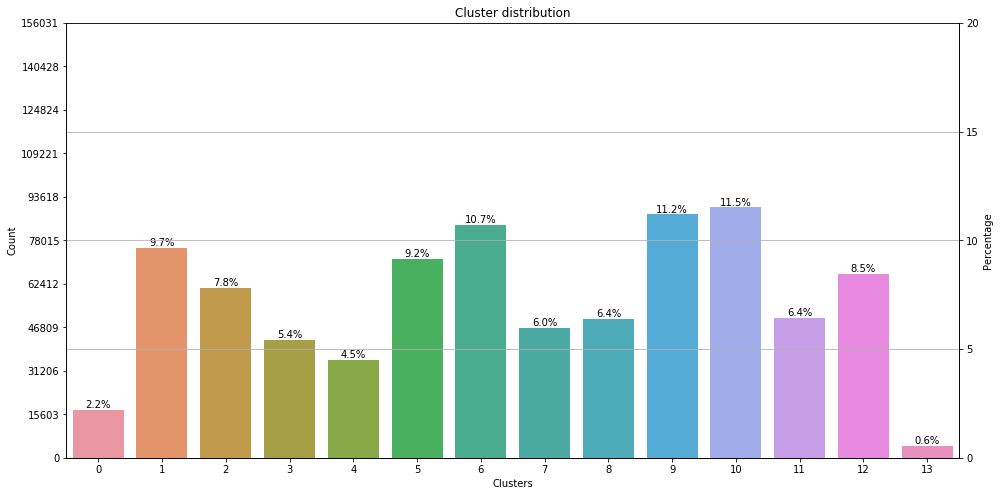

In [22]:
# Plot cluster distribution for general demographics (azdias)
plot_clusters(df_predictions_gen, 'Cluster', 20)

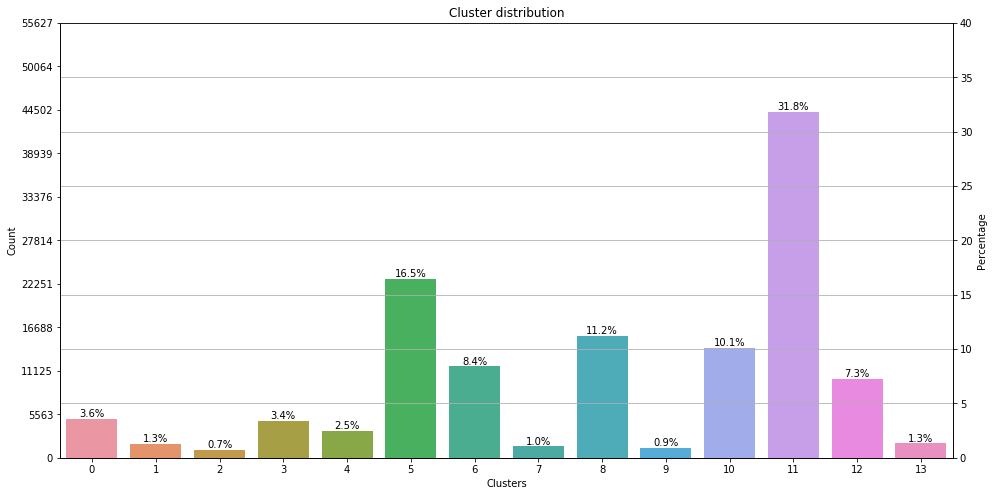

In [23]:
# Plot cluster distribution for customer demographics
plot_clusters(df_predictions_cust, 'Cluster', 40)

In [44]:
def get_ratios(gen_pred, cust_pred):
    '''
    Create new DataFrame of the ratios of proportions of customer and general demographic predictions.
    INPUT:
        gen_pred - cluster predictions for general demographics (numpy array)
        cust_pred - cluster predictions for customer demographic (numpy array)  
    OUTPUT:
        ratio_df - new DataFrame
    ''' 
    # Create new dataframe
    col_names =  ['gen_to_cust', 'cust_to_gen']
    ratio_df  = pd.DataFrame(columns = col_names)
    
    # Get total number for both datasets
    len_cust = len(cust_pred)
    len_gen = len(gen_pred)
    
    # Get value counts for each cluster for both datasets
    customers = pd.Series(cust_pred).value_counts().sort_index()
    general = pd.Series(gen_pred).value_counts().sort_index()
    
    # Calculate percentages
    cust_perc = customers.map(lambda x: round(x/len_cust * 100, 2))
    gen_perc = general.map(lambda x: round(x/len_gen * 100, 2))
    
    # Calculate ratios between general and customer data and vice versa
    ratio_df['gen_to_cust'] = round(gen_perc / cust_perc, 2)
    ratio_df['cust_to_gen'] = round(cust_perc / gen_perc, 2)
    
    return ratio_df

In [45]:
# Get DataFrame of the ratios
ratios = get_ratios(predictions_gen, predictions_cust)
ratios

,gen_to_cust,cust_to_gen
0,0.61,1.63
1,7.55,0.13
2,10.99,0.09
3,1.60,0.62
4,1.81,0.55
5,0.56,1.80
6,1.27,0.79
7,5.70,0.18
8,0.57,1.75
9,12.16,0.08


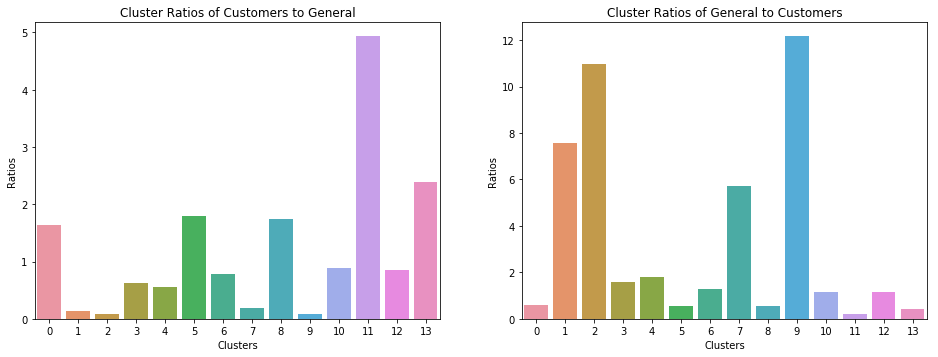

In [49]:
# Plot the ratios
plt.figure(figsize=(16,12))
plt.subplot(221)
sns.barplot(x = ratios.index, y = ratios['cust_to_gen']).set_title('Cluster Ratios of Customers to General')
plt.xlabel("Clusters")
plt.ylabel("Ratios")
plt.subplot(222)
sns.barplot(x = ratios.index, y = ratios['gen_to_cust']).set_title('Cluster Ratios of General to Customers')
plt.xlabel("Clusters")
plt.ylabel("Ratios")
plt.show()

In [29]:
def compare_plots(column, cust_data, gen_data):
    '''
    Compare target and non-target population plots for specific feature.
    INPUT:
        column - name of column (str)
        cust_data - 
        gen_data
    OUTPUT:
        None
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    # Target population plot
    sns.countplot(x = column, data=cust_data, ax=ax1)
    ax1.set_xlabel('Value')
    ax1.set_title('Target Population Distribution for {}'.format(column))
    sns.countplot(x = column, data=gen_data, ax=ax2)
    # Non-target population plot
    ax2.set_xlabel('Value')
    ax2.set_title('Non-target Population Distribution for {}'.format(column))
    fig.tight_layout()
    plt.show()

In [30]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Get indices of target population for cluster 11
target_indices_11 = df_predictions_cust[df_predictions_cust['Cluster'] == 11].index
# Make DataFrame subsetting customers (no encoding version) with the target indices
target_11 = customers_noenc.iloc[target_indices_11]
target_11.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
2655,4.0,2,2.0,4,1,5,1,2,4,5,...,1.0,5.0,5.0,3.0,6.0,3.0,3.0,0.0,5.0,1.0
2779,4.0,1,2.0,5,1,5,1,1,2,2,...,1.0,3.0,3.0,3.0,5.0,4.0,1.0,1.0,3.0,5.0
2938,4.0,1,2.0,5,1,5,1,2,2,5,...,0.0,2.0,3.0,1.0,4.0,1.0,1.0,1.0,2.0,2.0
3564,3.0,1,5.0,5,1,5,1,2,3,5,...,0.0,3.0,3.0,4.0,8.0,5.0,4.0,1.0,4.0,3.0
3758,4.0,2,2.0,5,1,5,2,1,3,6,...,0.0,2.0,3.0,3.0,5.0,3.0,1.0,0.0,2.0,5.0


In [31]:
# Get indices of non-target population for cluster 11
nontarget_indices_11 = df_predictions_gen[df_predictions_gen['Cluster'] == 11].index
# Make DataFrame subsetting customers with the target indices
nontarget_11 = azdias_noenc.iloc[target_indices_11]
nontarget_11.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1972,3.0,1,5.0,4,1,5,1,1,5,5,...,2.0,5.0,3.0,4.0,9.0,3.0,2.0,0.0,3.0,4.0
2096,4.0,2,2.0,5,1,5,1,1,3,2,...,0.0,4.0,5.0,2.0,4.0,3.0,2.0,1.0,1.0,5.0
2192,1.0,2,6.0,4,3,1,5,4,3,4,...,0.0,3.0,3.0,4.0,5.0,4.0,6.0,0.0,2.0,5.0
2763,1.0,2,2.0,1,5,3,5,4,5,1,...,2.0,5.0,3.0,3.0,7.0,3.0,6.0,0.0,4.0,5.0
2978,4.0,1,1.0,5,1,4,2,1,2,2,...,0.0,3.0,4.0,3.0,3.0,2.0,3.0,0.0,4.0,4.0


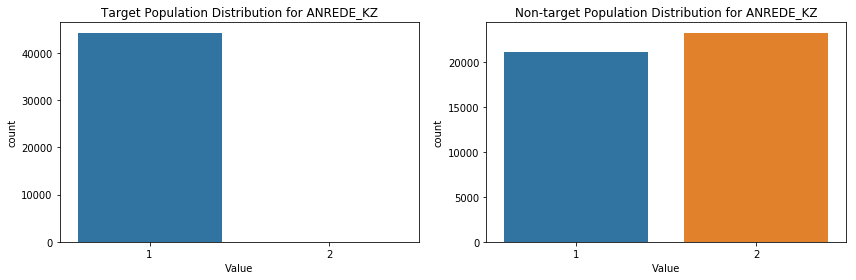

In [63]:
# Compare plots for gender
compare_plots('ANREDE_KZ', target_11, nontarget_11)

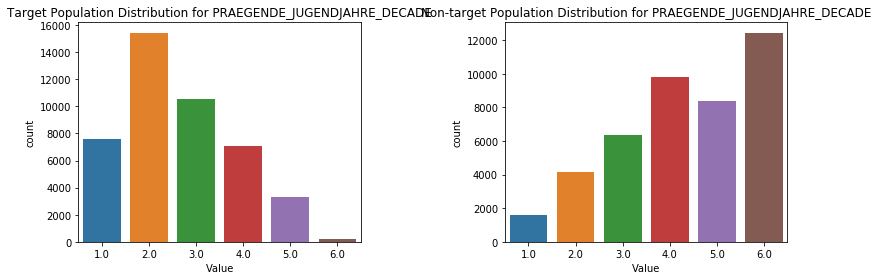

In [64]:
# Compare plots for decade
compare_plots('PRAEGENDE_JUGENDJAHRE_DECADE', target_11, nontarget_11)

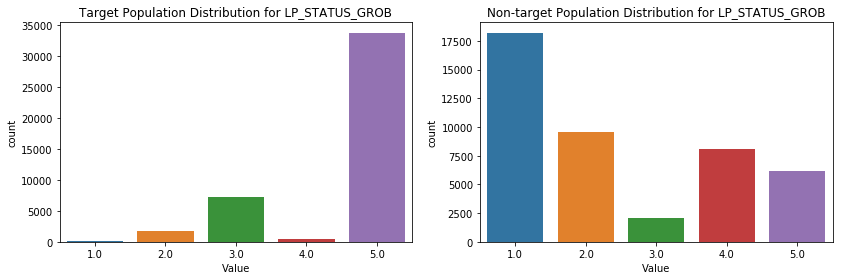

In [132]:
# Compare plots for social status, rough scale
compare_plots('LP_STATUS_GROB', target_11, nontarget_11)

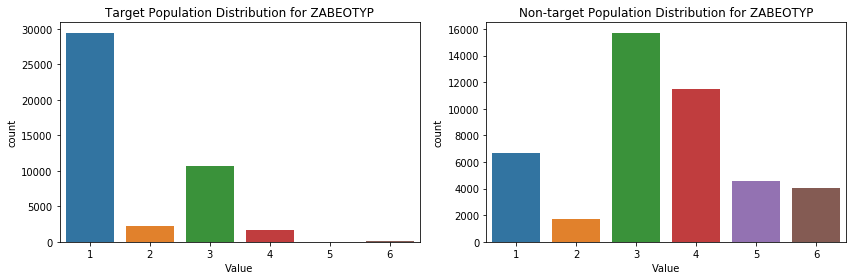

In [103]:
# Compare plots for energy consumption typology
compare_plots('ZABEOTYP', target_11, nontarget_11)

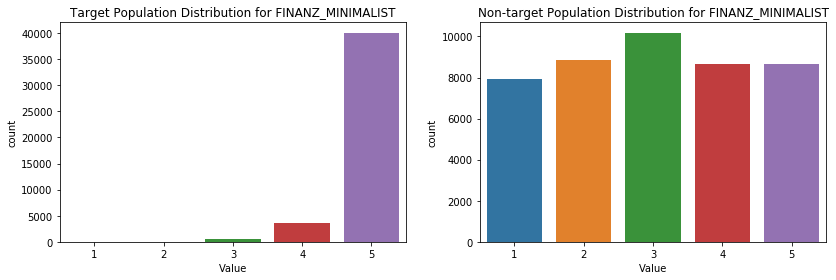

In [106]:
# Compare plots for low financial interest
compare_plots('FINANZ_MINIMALIST', target_11, nontarget_11)

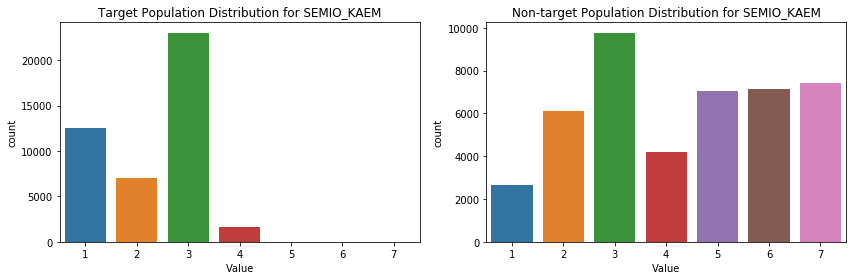

In [124]:
# Compare plots for combative attitude
compare_plots('SEMIO_KAEM', target_11, nontarget_11)

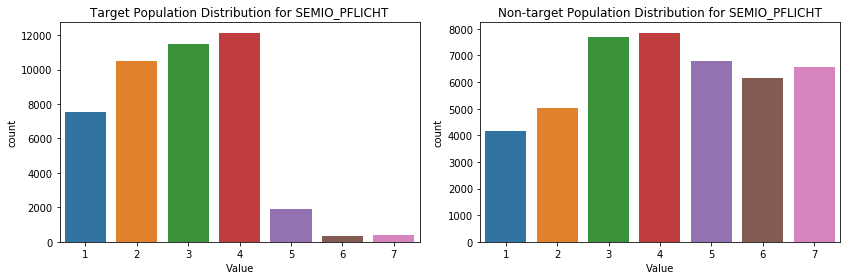

In [127]:
# Compare plots for dutiful
compare_plots('SEMIO_PFLICHT', target_11, nontarget_11)

In [32]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Get indices of target population for cluster 9
target_indices_9 = df_predictions_cust[df_predictions_cust['Cluster'] == 9].index
# Make DataFrame subsetting customers (no encoding version) with the target indices
target_9 = customers_noenc.iloc[target_indices_9]
target_9.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
4,3.0,1,6.0,3,1,4,4,5,2,2,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,0.0,4.0,1.0
21,4.0,1,1.0,3,1,5,2,1,4,6,...,1.0,4.0,3.0,1.0,3.0,1.0,3.0,0.0,4.0,3.0
93,4.0,1,1.0,5,1,5,1,1,2,6,...,1.0,5.0,5.0,3.0,7.0,5.0,3.0,1.0,5.0,4.0
97,2.0,1,5.0,3,3,4,1,2,2,5,...,0.0,3.0,3.0,4.0,8.0,4.0,5.0,1.0,4.0,5.0
109,4.0,1,4.0,5,1,5,1,1,3,5,...,2.0,5.0,3.0,4.0,6.0,5.0,2.0,1.0,5.0,4.0


In [33]:
# Get indices of non-target population for cluster 9
nontarget_indices_9 = df_predictions_gen[df_predictions_gen['Cluster'] == 9].index
# Make DataFrame subsetting customers with the target indices
nontarget_9 = azdias_noenc.iloc[target_indices_9]
nontarget_9.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
4,3.0,1,5.0,4,3,4,1,3,2,5,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
23,3.0,1,3.0,5,3,3,2,2,1,6,...,NaN,NaN,NaN,3.0,6.0,2.0,4.0,1.0,4.0,3.0
78,2.0,1,4.0,2,3,2,3,5,2,1,...,0.0,4.0,5.0,4.0,6.0,5.0,5.0,0.0,2.0,5.0
82,1.0,2,6.0,1,5,1,4,4,4,1,...,2.0,5.0,3.0,4.0,9.0,4.0,6.0,0.0,4.0,5.0
92,1.0,2,6.0,3,5,2,4,4,1,3,...,0.0,3.0,4.0,3.0,4.0,3.0,6.0,0.0,2.0,4.0


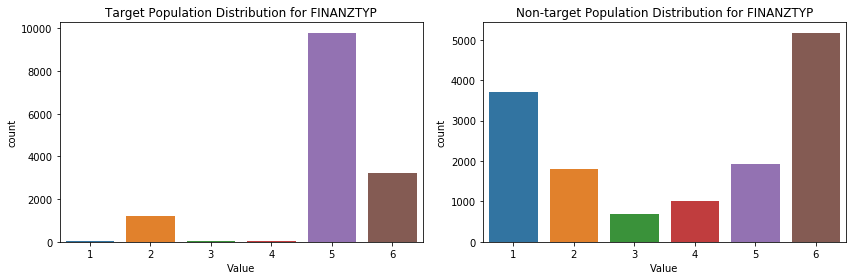

In [38]:
# Compare plots for most descriptive financial type for individual using cluster 9
compare_plots('FINANZTYP', target_9, nontarget_9)

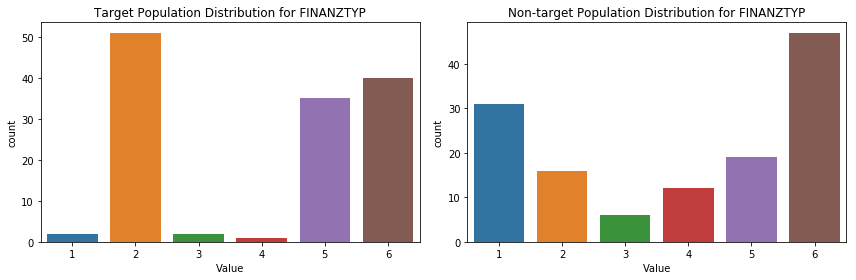

In [39]:
# Compare plots for most descriptive financial type for individual using cluster 11
compare_plots('FINANZTYP', target_11, nontarget_11)

### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster with a ratio greater than 2 in the "Cluster Ratios of Customers to General" graph is 11. This cluster was used to find types of people who are overrepresented in the customer data compared to the general population. 

There are several clusters with ratios greater than 2 in the "Cluster Ratios of General to Customers" graph. They are 1, 2, 7, and 9. Cluster 9, which has the biggest ratio, was used to find types of people who are underrepresented in the customer data compared to the general population. 

Since there appears to be participation bias when comparing the subset containing high missing values with the subset containing low missing values, only rows with less than or equal to 10 missing values were kept in the azdias and customer datasets for cluster analysis. 

Based on the PCA interpretations from STEP 2.3, the following features were explored using either cluster 9 or 11. 

ANREDE_KZ - Gender
-  1: male
-  2: female

Males are overwhelmingly popular with the mail-order company. 

PRAEGENDE_JUGENDJAHRE_DECADE
-  1: 40s 
-  2: 40s 
-  3: 50s 
-  4: 50s 
-  5: 60s 
-  6: 60s 
-  7: 60s 
-  8: 70s
-  9: 70s 
- 10: 80s 
- 11: 80s 
- 12: 80s 
- 13: 80s 
- 14: 90s 
- 15: 90s 

The mail-order company is more popular with older people. 

Conversely, those born in the 90s are considerably underrepresented. This seems to indicate that this age group has low interest in the company.

LP_STATUS_GROB - Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

Top earners are popular with the mail-order company.

ZABEOTYP - Energy consumption typology
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent

The mail-order company is popular with those who identify as green under energy consumption type. People who are price driven, seeking orientation, and indifferent are underrepresented.

FINANZ_MINIMALIST - low financial interest
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Those who chose very low (5) under FINANZ_MINIMALIST are overrepresented in the customer base. This implies that the customer base is least likely to exhibit low financial interest. 

FINANZTYP - most descriptive financial type for individual
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

Corresponding with FINANZ_MINIMALIST, customers are least likely to be of the financial type, MINIMALIST. 

SEMIO-KAEM - combative attitude, SEMIO-PLICHT - dutiful
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity

Those with higher affinity to the personality types SEMIO-KAEM and SEMIO-PLICHT are more popular with the mail-order company.

In summary, the mail-order company should target environmentally conscious, high-income males born between 1940 to 1970 with combative and dutiful personality types.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [2]:
# Get versions of software used
!pip list

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
altair (1.2.1)
asn1crypto (0.22.0)
atari-py (0.1.7)
attrs (19.1.0)
audioread (2.1.4)
av (0.3.3)
awscli (1.16.17)
backcall (0.1.0)
backports.functools-lru-cache (1.4)
backports.weakref (1.0rc1)
beautifulsoup4 (4.6.0)
bleach (1.5.0)
blinker (1.4)
bokeh (0.12.13)
boto (2.48.0)
boto3 (1.9.7)
botocore (1.12.7)
Box2D (2.3.2)
Box2D-kengz (2.3.3)
bresenham (0.2)
bz2file (0.98)
cassandra-driver (3.11.0)
certifi (2017.11.5)
cffi (1.11.2)
chardet (3.0.4)
click (6.7)
cloudpickle (0.2.2)
colorama (0.3.9)
colour (0.1.5)
conda (4.6.9)
cryptography (2.1.4)
cycler (0.10.0)
Cython (0.29.6)
dask (0.16.1)
decorator (4.0.11)
defusedxml (0.5.0)
dill (0.2.7.1)
docutils (0.14)
dronekit (2.9.1)
entrypoints (0.2.3)
et-xmlfile (1.0.1)
eventlet (0.22.0)
fastcache (1.0.2)
Flask (0.12.2)
Flask-SocketIO (2.

In [1]:
# List python version
from platform import python_version
print(python_version())

3.6.3


In [40]:
# Convert notebook to html
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 1786539 bytes to Identify_Customer_Segments.html']